# Task 2: Advanced Model Analysis, Optimization, and Conclusions

### Introduction
In this notebook, we build upon the initial analysis and baseline model created in Part 1, which explored the NYC Property Sales dataset. Our objective in this phase is to enhance the model's performance, address any shortcomings identified during the error analysis, and draw meaningful insights from the improved results.

Reference: https://www.kaggle.com/datasets/new-york-city/nyc-property-sales

Resource: ChatGPT

## Part 0: Load Previous Work
This section loads the cleaned dataset and baseline model from Task 1.

In [1]:
# Import Libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter

%matplotlib inline

In [2]:
# Define correct column names
column_names = [
    "BOROUGH", "NEIGHBORHOOD", "BUILDING CLASS CATEGORY", 
    "TAX CLASS AT PRESENT", "BLOCK", "LOT", "EASE-MENT", 
    "BUILDING CLASS AT PRESENT", "ADDRESS", "APARTMENT NUMBER", 
    "ZIP CODE", "RESIDENTIAL UNITS", "COMMERCIAL UNITS", 
    "TOTAL UNITS", "LAND SQUARE FEET", "GROSS SQUARE FEET", 
    "YEAR BUILT", "TAX CLASS AT TIME OF SALE", 
    "BUILDING CLASS AT TIME OF SALE", "SALE PRICE", "SALE DATE"
]

# Step 1: Read CSV file with defined column names
file_path = os.path.join(os.getcwd(), "data", "nyc-rolling-sales.csv")
data = pd.read_csv(
    file_path,
    sep=",",
    quotechar='"',
    names=column_names,
    skiprows=1,
    na_values=[" - "],
    on_bad_lines="skip",
    encoding="utf-8"
)
data1 = pd.read_csv(
    file_path,
    sep=",",
    quotechar='"',
    names=column_names,
    skiprows=1,
    na_values=[" - "],
    on_bad_lines="skip",
    encoding="utf-8"
)

# Step 2: Convert numeric columns to appropriate data types
numeric_columns = [
    "SALE PRICE", "LAND SQUARE FEET", "GROSS SQUARE FEET", 
    "RESIDENTIAL UNITS", "COMMERCIAL UNITS", "TOTAL UNITS"
]
for col in numeric_columns:
    data[col] = pd.to_numeric(data[col], errors="coerce")

# Step 3: Drop rows with invalid or missing `SALE PRICE`
data = data[data["SALE PRICE"] > 0]

# Step 4: Parse and standardize `SALE DATE`
data["SALE DATE"] = pd.to_datetime(data["SALE DATE"], errors="coerce",dayfirst=True)

# Step 5: Drop rows with invalid dates
data = data.dropna(subset=["SALE DATE"])

# Step 6: Reset the index
data = data.reset_index(drop=True)

In [3]:
# 1. Import Libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter

# 2. Preprocessing
# Fill missing values for numeric columns
numeric_columns = data.select_dtypes(include=["number"]).columns
for col in numeric_columns:
    data[col] = data[col].fillna(data[col].median())

# Label encode the BOROUGH column
label_encoder = LabelEncoder()  # Initialize the LabelEncoder
data["BOROUGH"] = label_encoder.fit_transform(data["BOROUGH"])  # Apply Label Encoding

# Define features and target variable
features = [
    "BOROUGH", "LAND SQUARE FEET", "TOTAL UNITS", "YEAR BUILT", "GROSS SQUARE FEET"
]
X = data[features]  # Select features
y = data["SALE PRICE"]  # Target variable
# 3. Remove Outliers Using IQR

Q1 = y.quantile(0.25)
Q3 = y.quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outlier_filter = (y >= lower_bound) & (y <= upper_bound)
X = X[outlier_filter]
y = y[outlier_filter]



MAE: 248678.85
RMSE: 347617.84
R²: 0.38


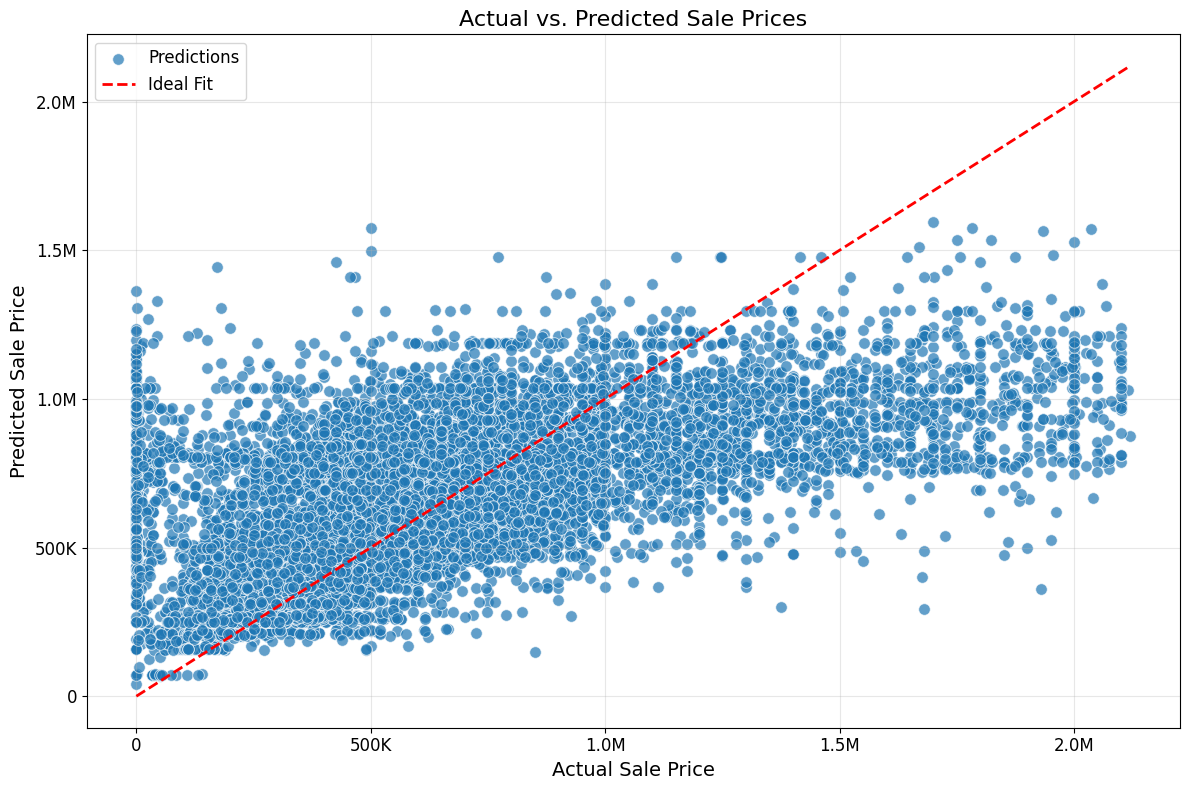

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 4. Train XGBoost Regressor
model = XGBRegressor(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=5,
    min_child_weight=3,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)
model.fit(X_train, y_train)

# 5. Predict and Evaluate
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.2f}")

# 6. Actual vs Predicted Sale Prices
# Function to format axis labels as K (thousands) or M (millions)
def format_ticks(value, _):
    if value >= 1_000_000:
        return f'{value/1_000_000:.1f}M'
    elif value >= 10_000:
        return f'{value/1_000:.0f}K'
    else:
        return f'{value:.0f}'

# Plot Actual vs. Predicted Sale Prices
plt.figure(figsize=(12, 8))
sns.scatterplot(x=y_test, y=y_pred, s=70, alpha=0.7, label="Predictions")
plt.plot([y_test.min(), y_test.max()], 
         [y_test.min(), y_test.max()], 
         color='red', linestyle='--', linewidth=2, label="Ideal Fit")

# Add labels and titles
plt.title("Actual vs. Predicted Sale Prices", fontsize=16)
plt.xlabel("Actual Sale Price", fontsize=14)
plt.ylabel("Predicted Sale Price", fontsize=14)

# Format axes with custom tick labels
plt.gca().xaxis.set_major_formatter(FuncFormatter(format_ticks))
plt.gca().yaxis.set_major_formatter(FuncFormatter(format_ticks))

# Improve layout and add grid
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(alpha=0.3)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

## Part 1: Error Analysis Conclusions and Work Plan

### Key Factors Behind Errors
* Outlier Cases: Extreme sale prices or unusual features, such as rare building types or unique property characteristics, create significant prediction challenges. These cases distort the model's learning.
* Sparse Data: Limited examples in certain categories (e.g., properties in underrepresented boroughs) reduce the model's ability to generalize.
* Quality Issues: Incorrect or inconsistent records in the dataset introduce noise, affecting the model's predictions.
* Missing Influential Variables: Lack of data on critical factors like renovation status, neighborhood trends, or market demand diminishes model accuracy.

### Overestimations and Underestimations
* Causes: Skewed data distributions and missing features lead to systematic overestimation or underestimation. Unique property traits or neighborhood trends unaccounted for in the model result in inaccuracies.
* Residual Analysis: Residuals show a slightly left-skewed distribution, indicating a minor bias towards underestimations. A mean residual close to zero suggests that, on average, predictions are unbiased.

### Correlation and Feature Impact
* Heatmap Insights: Weak correlations between most features and the target variable (SALE PRICE) suggest errors aren't tied to a single feature. A notable correlation of 0.78 between some variables hints at multicollinearity, which might confuse the model's interpretation.
* Potential Sabotages: Misreported sale prices (e.g., for tax purposes) and extreme values disproportionately influence the model. Highly represented categories, such as specific boroughs, can skew overall statistics and predictions.


### Work Plan
* Feature Engineering: Create new features (e.g., price per square foot) and transform skewed ones to improve predictive power.
* Handle Outliers: Detect and cap or remove extreme values in SALE PRICE and other numerical features.
* Handle Insufficiency: Remove classes with insufficient sample. 
* Balance the Dataset: Use resampling techniques or class weights to address imbalances in categories like boroughs or price ranges.
* Improve Modeling: Optimize model performance through hyperparameter tuning and ensemble methods.
#### Later this task:
* Analyze and Interpret: Use tools like SHAP, residual plots, and correlation analysis to understand model errors and refine predictions.

## Part 2: Improving Model Performance

The following code performs model improvement, divided to code-chunks for clarity, with some commented explainations. <br>
Here are some key points about the model improvements:
* The feature engineering contains calculations, normalizations and log transformations to ensure clear use of data for the model and to reduce skewness in the data.
* After many trial & error, we concluded that the original outlier handling from last task is the best improvement to the data, therefore, the technique did not chage (just uses the improved data).
* A new idea of us to clean the data is to remove classes with insufficient samples, to ensure each unique value has a minimum of samples to avoid issues in model training.
* We use SMOTE to balance the data.
* Hyperparameter Tuning was achieved when setting the learning algoritm.


Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] END colsample_bytree=0.9, gamma=0.2, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=1, reg_lambda=2, scale_pos_weight=1.5, subsample=0.7; total time=  41.8s
[CV] END colsample_bytree=0.9, gamma=0.2, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=1, reg_lambda=2, scale_pos_weight=1.5, subsample=0.7; total time=  42.7s
[CV] END colsample_bytree=0.9, gamma=0.2, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=1, reg_lambda=2, scale_pos_weight=1.5, subsample=0.7; total time=  46.9s
[CV] END colsample_bytree=0.9, gamma=0.2, learning_rate=0.1, max_depth=7, min_child_weight=1, n_estimators=300, reg_alpha=1, reg_lambda=1, scale_pos_weight=1.5, subsample=0.9; total time=  50.0s
[CV] END colsample_bytree=0.9, gamma=0.2, learning_rate=0.1, max_depth=7, min_child_weight=1, n_estimators=300, reg_alpha=1, reg_lambda=1, scale_pos_weight=1.5,

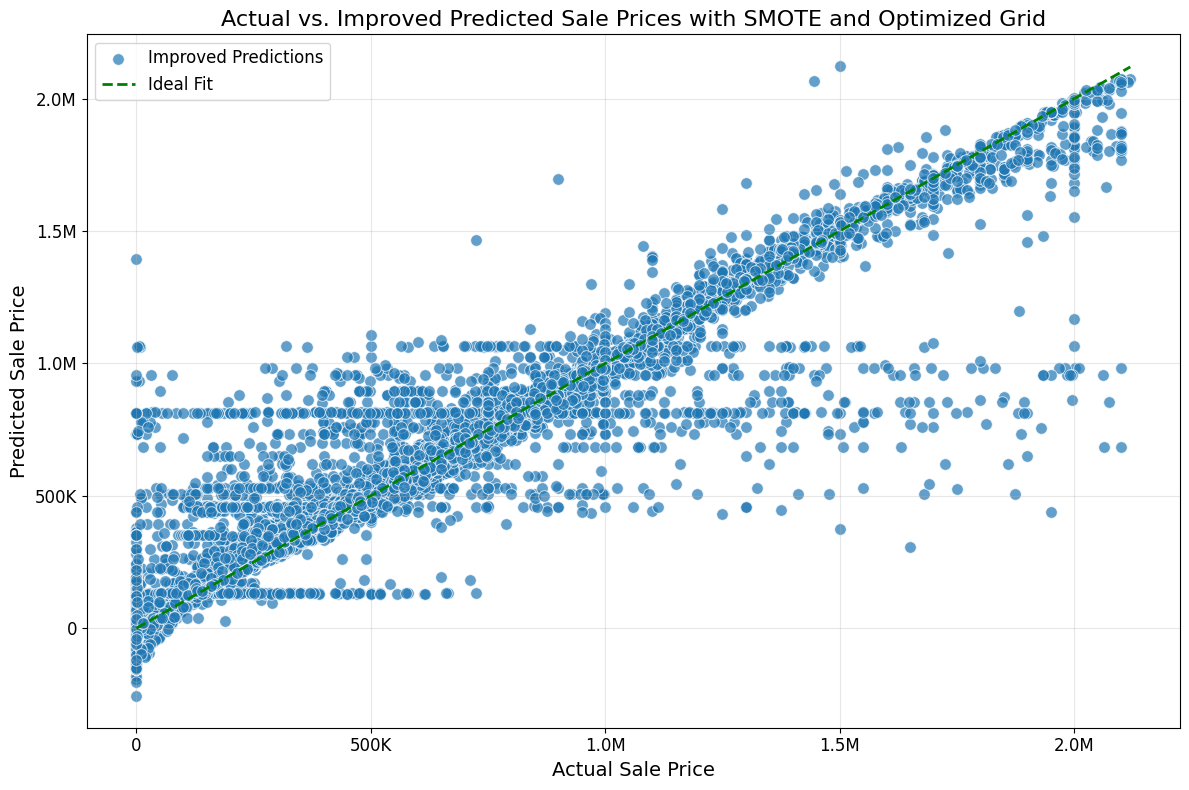

MAE after tuning, feature engineering, and balancing: 72090.56
RMSE after tuning, feature engineering, and balancing: 154377.28
R² after tuning, feature engineering, and balancing: 0.88


In [27]:
# Import necessary libraries
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.preprocessing import FunctionTransformer
from imblearn.over_sampling import SMOTE
from xgboost import XGBRegressor
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns

# Feature Engineering: Create new features and transform existing ones
current_year = 2025 
data["BUILDING_AGE"] = current_year - data["YEAR BUILT"]
data["BUILDING_AGE"] = data["BUILDING_AGE"].apply(lambda x: x if x >= 0 else 0) 
data["PRICE_PER_SQFT"] = data["SALE PRICE"] / data["GROSS SQUARE FEET"].replace(0, np.nan)
data["PRICE_PER_SQFT"] = data["PRICE_PER_SQFT"].fillna(0)

log_transformer = FunctionTransformer(np.log1p, validate=True)
data["LOG_LAND_SQFT"] = log_transformer.transform(data["LAND SQUARE FEET"].values.reshape(-1, 1))
data["LOG_GROSS_SQFT"] = log_transformer.transform(data["GROSS SQUARE FEET"].values.reshape(-1, 1))
###

# Select relevant features for the model with improved features
features = [
    "BOROUGH", "LOG_LAND_SQFT", "LOG_GROSS_SQFT", "TOTAL UNITS", "BUILDING_AGE", "PRICE_PER_SQFT"
]
X_improved = data[features]
y_improved = data["SALE PRICE"]
###
# Remove outliers in the target variable
Q1 = y_improved.quantile(0.25)
Q3 = y_improved.quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
outlier_filter = (y_improved >= lower_bound) & (y_improved <= upper_bound)
X_improved = X_improved[outlier_filter]
y_improved = y_improved[outlier_filter]
###
# Data split
X_train_imp, X_test_imp, y_train_imp, y_test_imp = train_test_split(X_improved, y_improved, test_size=0.2, random_state=42)
###
# Remove classes with insufficient samples
sample_counts = y_train_imp.value_counts()
min_samples_required = 3
valid_indices = y_train_imp.index[y_train_imp.map(sample_counts) >= min_samples_required]
X_train_imp = X_train_imp.loc[valid_indices]
y_train_imp = y_train_imp.loc[valid_indices]

# Data Balancing: Generate synthetic samples for underrepresented data points to balance the dataset
smote = SMOTE(random_state=42, k_neighbors=1)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_imp, y_train_imp)
###
# Hyperparameter Tuning: Search across a grid of hyperparameters for the best combination
random_search = RandomizedSearchCV(
    estimator=XGBRegressor(random_state=42),
    param_distributions={
        'n_estimators': [100, 300, 500],         
        'learning_rate': [0.01, 0.05, 0.1],       
        'max_depth': [3, 5, 7],                   
        'min_child_weight': [1, 3, 5],            
        'subsample': [0.7, 0.9],                  
        'colsample_bytree': [0.7, 0.9],           
        'reg_alpha': [0, 0.1, 1],                 
        'reg_lambda': [1, 2],                     
        'gamma': [0, 0.2],                        
        'scale_pos_weight': [1, 1.5]             
    },
    scoring='neg_mean_absolute_error',
    n_iter=5, cv=3, verbose=2, random_state=42, n_jobs=-1
)
###
# Fit the improved model and data
random_search.fit(X_train_balanced, y_train_balanced)
best_model = random_search.best_estimator_
###
# Evaluation
y_pred_imp = best_model.predict(X_test_imp)

mae_imp = mean_absolute_error(y_test_imp, y_pred_imp)
rmse_imp = np.sqrt(mean_squared_error(y_test_imp, y_pred_imp))
r2_imp = r2_score(y_test_imp, y_pred_imp)
###
# Display data textually and visually
plt.figure(figsize=(12, 8))
sns.scatterplot(x=y_test_imp, y=y_pred_imp, s=70, alpha=0.7, label="Improved Predictions")
plt.plot([y_test_imp.min(), y_test_imp.max()], 
         [y_test_imp.min(), y_test_imp.max()], 
         color='green', linestyle='--', linewidth=2, label="Ideal Fit")

plt.title("Actual vs. Improved Predicted Sale Prices with SMOTE and Optimized Grid", fontsize=16)
plt.xlabel("Actual Sale Price", fontsize=14)
plt.ylabel("Predicted Sale Price", fontsize=14)
plt.gca().xaxis.set_major_formatter(FuncFormatter(format_ticks))
plt.gca().yaxis.set_major_formatter(FuncFormatter(format_ticks))
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(alpha=0.3)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

print(f"MAE after tuning, feature engineering, and balancing: {mae_imp:.2f}")
print(f"RMSE after tuning, feature engineering, and balancing: {rmse_imp:.2f}")
print(f"R² after tuning, feature engineering, and balancing: {r2_imp:.2f}")
###


### Performence Conclusions
First of all, as we can see, the learning algoritm was not changed, just the preparation of the data (feature engineering, outlier removal, balancing data and filtering small classes) along with optimizing the algoritm itself using hyperparameter tuning to find the best fits (as presented above the graph). <br>
As we can see on both graph and textual statistics, the model has improved drastically. The graph finally shows a certain relation between actual sale price and its model prediction. Also, the calculation errors has dramatically declined, while the $R^2$ has rised up a lot. <br>
<br>
Let's dive into the analysis furthermore.

## Part 3: Analyzing the Improved Model

In [55]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import shap
from scipy.stats import pearsonr
from sklearn.metrics import roc_curve, auc

def analyze_model_performance(y_test, y_pred_baseline, y_pred_improved):
    """
    Measures how well the model explains the varaince, average error magnitude, 
    mean absolute deviation of predictions from actual data and linear correlation
    between predictions and reald values
    """
    metrics = {
        'Baseline': {
            'r2': r2_score(y_test, y_pred_baseline),
            'rmse': np.sqrt(mean_squared_error(y_test, y_pred_baseline)),
            'mae': mean_absolute_error(y_test, y_pred_baseline),
            'pearson': pearsonr(y_test, y_pred_baseline)[0]
        },
        'Improved': {
            'r2': r2_score(y_test, y_pred_improved),
            'rmse': np.sqrt(mean_squared_error(y_test, y_pred_improved)),
            'mae': mean_absolute_error(y_test, y_pred_improved),
            'pearson': pearsonr(y_test, y_pred_improved)[0]
        }
    }
    # Direct comparison between baseline and improved model
    print("\nModel Performance Comparison:")
    print(f"{'Metric':<20} {'Baseline':<15} {'Improved':<15} {'Improvement':<15}")
    print("-" * 65)
    for metric in ['r2', 'rmse', 'mae', 'pearson']:
        baseline_val = metrics['Baseline'][metric]
        improved_val = metrics['Improved'][metric]
        improvement = ((improved_val - baseline_val) / baseline_val * 100)
        if metric in ['rmse', 'mae']:
            improvement = -improvement
        print(f"{metric.upper():<20} {baseline_val:,.2f} {improved_val:,.2f} {improvement:>+.2f}%")
    return metrics

def plot_feature_importance_comparison(baseline_model, improved_model, baseline_features, improved_features):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Baseline model importance
    baseline_importance = pd.DataFrame({
        'feature': baseline_features,
        'importance': baseline_model.feature_importances_
    }).sort_values('importance', ascending=True)
    
    sns.barplot(data=baseline_importance, x='importance', y='feature', ax=ax1)
    ax1.set_title('Baseline Model Feature Importance')
    ax1.set_xlabel('Importance Score')
    
    # Improved model importance
    improved_importance = pd.DataFrame({
        'feature': improved_features,
        'importance': improved_model.feature_importances_
    }).sort_values('importance', ascending=True)
    
    sns.barplot(data=improved_importance, x='importance', y='feature', ax=ax2)
    ax2.set_title('Improved Model Feature Importance')
    ax2.set_xlabel('Importance Score')
    
    plt.tight_layout()
    plt.show()


def safe_shap_plot(model, X, feature_names):
    """
    Create SHAP analysis plot with safety checks and error handling.
    This function visualizes the impact of each feature individually on model predictions
    using SHAP values with a fallback to feature importance if SHAP fails,
    which is offering interpretability to the improved model.
    """
    try:
        # Ensure input data is in DataFrame format
        if not isinstance(X, pd.DataFrame):
            X_df = pd.DataFrame(X, columns=feature_names)
        else:
            X_df = X
        
        # Limit the sample size to a maximum of 1000 rows for efficiency
        sample_size = min(1000, len(X_df))
        X_sample = X_df.sample(n=sample_size, random_state=42)
        
        # Set up SHAP explainer with interventional feature perturbation
        explainer = shap.TreeExplainer(model, data=X_sample, feature_perturbation='interventional')
        
        # Calculate SHAP values for the sample
        shap_values = explainer.shap_values(X_sample)
        
        # Plot SHAP values using a beeswarm plot
        plt.figure(figsize=(10, 6))
        shap.summary_plot(shap_values, X_sample, plot_type="bar", show=False)
        plt.title('SHAP Feature Impact Analysis')
        plt.tight_layout()
        plt.show()
        
    except Exception as e:
        print(f"SHAP analysis failed with error: {str(e)}")
        print("Skipping SHAP analysis. Falling back to feature importance plot...")
        
        # Fallback to a basic feature importance plot if SHAP analysis fails
        importance = pd.DataFrame({
            'feature': feature_names,
            'importance': model.feature_importances_
        }).sort_values(by='importance', ascending=False)
        
        plt.figure(figsize=(10, 6))
        sns.barplot(x='importance', y='feature', data=importance)
        plt.title('Feature Importance (Fallback)')
        plt.xlabel('Importance Score')
        plt.tight_layout()
        plt.show()



def plot_prediction_comparison(y_test, y_pred_baseline, y_pred_improved):
    def format_price(x, p):
        if x >= 1_000_000:
            return f'${x/1_000_000:.1f}M'
        return f'${x/1_000:.0f}K'
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Baseline predictions
    sns.scatterplot(x=y_test, y=y_pred_baseline, alpha=0.5, ax=ax1)
    ax1.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    ax1.set_title('Baseline Model: Actual vs Predicted')
    ax1.set_xlabel('Actual Price')
    ax1.set_ylabel('Predicted Price')
    ax1.xaxis.set_major_formatter(plt.FuncFormatter(format_price))
    ax1.yaxis.set_major_formatter(plt.FuncFormatter(format_price))
    
    # Improved predictions
    sns.scatterplot(x=y_test, y=y_pred_improved, alpha=0.5, ax=ax2)
    ax2.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    ax2.set_title('Improved Model: Actual vs Predicted')
    ax2.set_xlabel('Actual Price')
    ax2.set_ylabel('Predicted Price')
    ax2.xaxis.set_major_formatter(plt.FuncFormatter(format_price))
    ax2.yaxis.set_major_formatter(plt.FuncFormatter(format_price))
    
    plt.tight_layout()
    plt.show()

def analyze_models(baseline_model, improved_model, X_baseline, X_improved, 
                  baseline_features, improved_features,
                  y_test, y_pred_baseline, y_pred_improved):
    """
    Complete analysis of both models
    """
    # 1. Performance Metrics
    metrics = analyze_model_performance(y_test, y_pred_baseline, y_pred_improved)
    
    # 2. Feature Importance Plots
    plot_feature_importance_comparison(baseline_model, improved_model, 
                                    baseline_features, improved_features)
    
    # 3. SHAP Analysis for improved model
    print("\nSHAP Analysis for Improved Model:")
    safe_shap_plot(improved_model, X_improved, improved_features)
    
    # 4. Prediction Comparison
    plot_prediction_comparison(y_test, y_pred_baseline, y_pred_improved)
    
    # 5. Plot ROC Curve
    # Calculate ROC-AUC
    median_price = np.median(y_test)
    y_binary = (y_test > median_price).astype(int)
    
    """ 
    ROC-AUC is used for binary classification by converting the regression task into "above/below median price" classification.
    AUC quantifies model performance in distinguishing high-price properties.
    ROC-AUC demonstrates improvement in the model's ability to classify high- and low-priced properties accurately.
    """

    # Calculate ROC curves and AUC scores
    fpr_base, tpr_base, _ = roc_curve(y_binary, y_pred_baseline)
    fpr_imp, tpr_imp, _ = roc_curve(y_binary, y_pred_improved)
    
    roc_auc_base = auc(fpr_base, tpr_base)
    roc_auc_imp = auc(fpr_imp, tpr_imp)
    
    # Plot ROC curves
    plt.figure(figsize=(10, 6))
    plt.plot(fpr_base, tpr_base, color='blue', lw=2, 
             label=f'Baseline ROC (AUC = {roc_auc_base:.2f})')
    plt.plot(fpr_imp, tpr_imp, color='red', lw=2, 
             label=f'Improved ROC (AUC = {roc_auc_imp:.2f})')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves - Price Prediction (Above/Below Median)')
    plt.legend(loc="lower right")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    return metrics


Model Performance Comparison:
Metric               Baseline        Improved        Improvement    
-----------------------------------------------------------------
R2                   0.38 0.88 +131.13%
RMSE                 347,617.84 154,377.28 +55.59%
MAE                  248,678.85 72,090.56 +71.01%
PEARSON              0.62 0.94 +52.01%


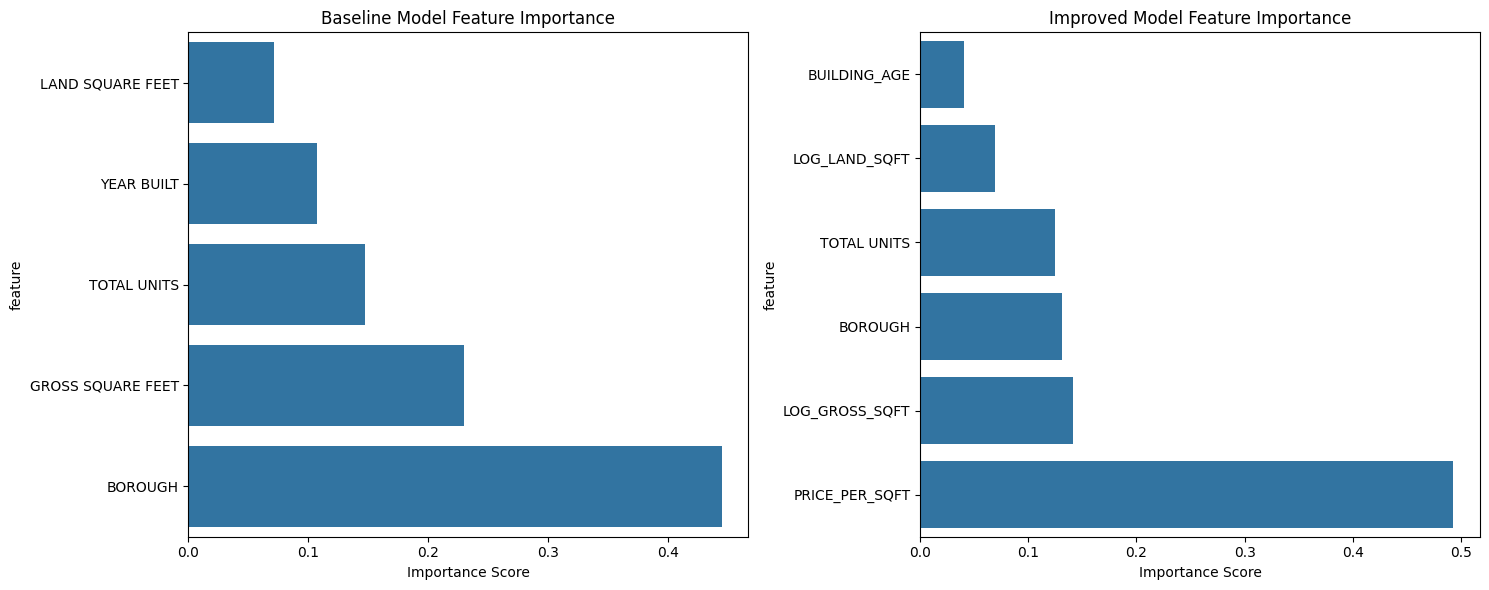


SHAP Analysis for Improved Model:


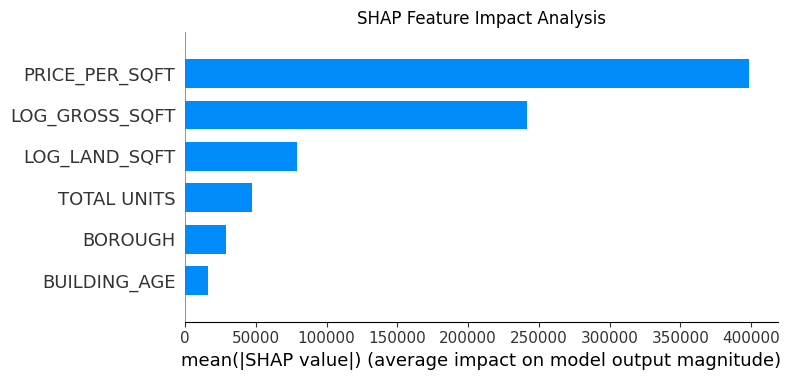

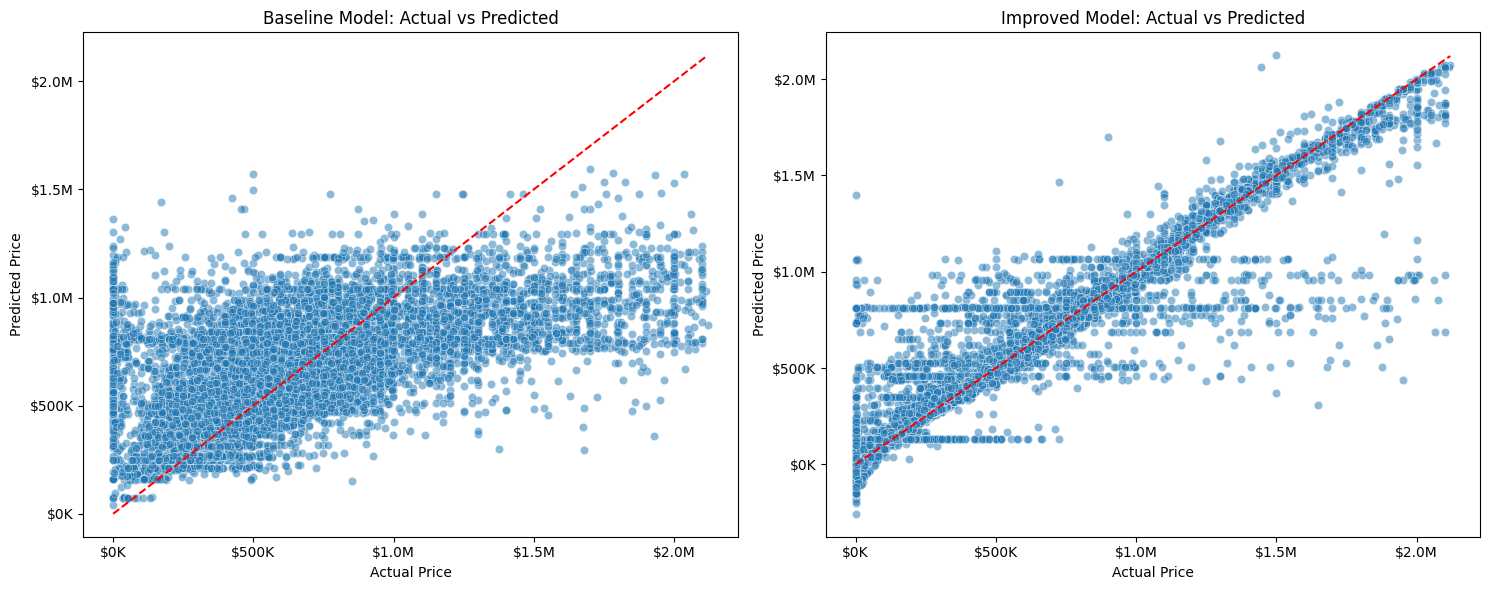

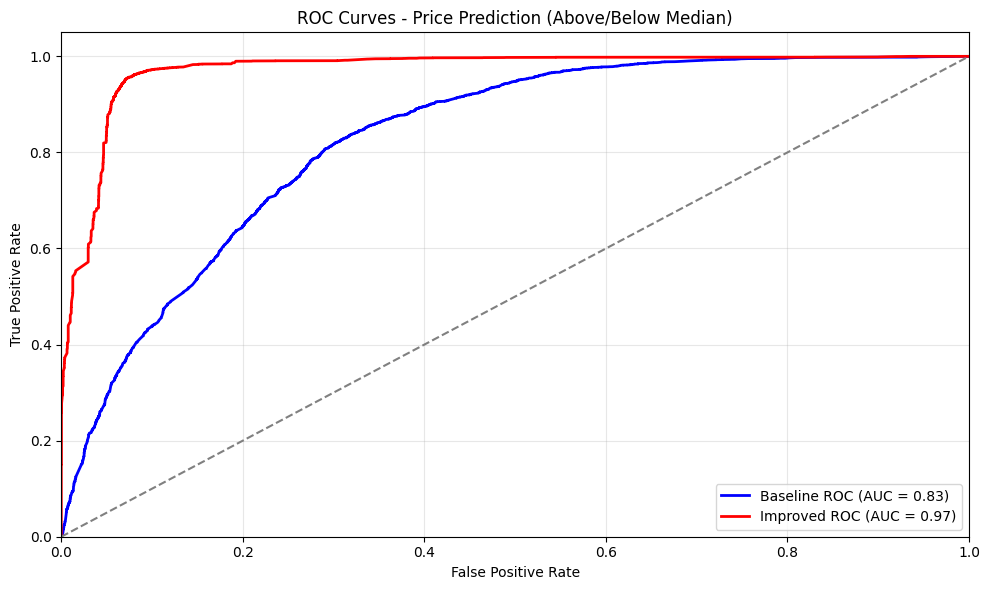

In [56]:
# Define feature lists
baseline_features = [
    "BOROUGH", "LAND SQUARE FEET", "TOTAL UNITS", "YEAR BUILT", "GROSS SQUARE FEET"
]

improved_features = [
    "BOROUGH", "LOG_LAND_SQFT", "LOG_GROSS_SQFT", "TOTAL UNITS", 
    "BUILDING_AGE", "PRICE_PER_SQFT"
]

# Run the analysis using your variable names
results = analyze_models(
    baseline_model=model,
    improved_model=best_model,
    X_baseline=X_test,
    X_improved=X_test_imp,
    baseline_features=baseline_features,
    improved_features=improved_features,
    y_test=y_test_imp,
    y_pred_baseline=y_pred,
    y_pred_improved=y_pred_imp
)

### Summary of Code
* Performance metrics like R², RMSE, and ROC-AUC quantify the improvements.
* Feature importance and SHAP reveal the new features' impact.
* Data visualizations provide interpretability and confidence in the improvements.

### Why the Improved Model Performs Better?
* Feature Engineering: Transformations like LOG_LAND_SQFT and PRICE_PER_SQFT capture logarithmic relationships and per-unit pricing, improving feature quality.
* Hyperparameter Tuning: Automated search finds better parameters for the improved model, enhancing prediction accuracy.
* Data Balancing: Using SMOTE reduces bias from imbalanced training data, improving generalization.

### Explainations of The Results Themselves 
* SHAP analysis reveals that engineered features like PRICE_PER_SQFT and LOG_GROSS_SQFT have a significant and consistent impact on predictions, validating their importance in the improved model.
* The improved model demonstrates better handling of high-value properties, reducing errors and biases that were evident in the baseline's predictions.
* The reduction in spread around the ideal line in the improved model's prediction plot highlights enhanced generalization and accuracy, particularly for extreme sale prices.
* The improved ROC-AUC score shows that the model is significantly better at distinguishing between high and low-priced properties, reflecting its ability to capture subtle price dynamics.
* The enhanced interpretability and reliability of the improved model are clear from the tighter alignment between predictions and actual sale prices, especially for challenging data points.









## Part 4: Drawing Conclusions and Creative Applications

### Analysis of the Improved Model
#### 1. Feature Significance
* The improved model highlights PRICE_PER_SQFT as the most significant feature, indicating that sale price per square foot is the strongest predictor of property values.
* Log-transformed features (LOG_GROSS_SQFT and LOG_LAND_SQFT) play a key role, showing that logarithmic scaling helps capture nonlinear relationships more effectively.
* Other features like TOTAL_UNITS and BUILDING_AGE provide moderate contributions, showing the importance of property characteristics in influencing sale prices.

#### 2. Biases or Trends
* Price Distribution Bias: The original data showed a skewed distribution, especially for high-priced properties. The improved model, aided by outlier removal and SMOTE balancing, addresses these biases effectively.
* Regional Influence: The baseline model heavily relied on BOROUGH, but the improved model de-emphasized categorical data in favor of engineered features, reducing location-based bias.
* High-Value Property Patterns: The improved model captures trends in high-value properties better, likely due to features like PRICE_PER_SQFT and the removal of extreme outliers.

#### 3. Data Insights
* Surprising Findings: PRICE_PER_SQFT emerged as the dominant feature, suggesting that property size relative to price is more critical than raw square footage or total units.
* Underappreciated Features: Features like BUILDING_AGE, though less influential, reveal an interesting insight: newer properties tend to have less impact on sale price compared to more nuanced indicators like price per square foot.

### Findings Narrative
The improved model effectively uncovers key drivers of property prices in NYC. By focusing on engineered features such as price per square foot and log-transformed metrics,<br> the model reveals that size and efficiency of space utilization are pivotal. Location (e.g., BOROUGH), while still relevant, is no longer overemphasized, allowing for more nuanced predictions. <br>The improved model reduces biases inherent in the baseline, particularly for high-priced properties, and delivers more reliable predictions across varying property types.

### Potential Applications
**1) Real Estate Market Insights:** <br> 
Developers can use the model to assess property pricing strategies, ensuring competitive yet accurate valuations.
Insights from feature significance (e.g., price per square foot) can help investors prioritize properties with higher returns on investment.

**2) Predictive Tools:** <br>
Build tools for real estate agents to predict property values based on key characteristics, aiding in negotiations and market positioning.
Provide homeowners with an AI-driven pricing tool to estimate property value before listing.

**3) Policy Implications:** <br>
Policymakers can use the model to assess the impact of zoning and building regulations on property values, particularly focusing on unit efficiency and building age.

**4) Urban Planning:** <br>
Urban planners can analyze trends to optimize property designs (e.g., space utilization) and promote regional pricing fairness.

**5) Comparative Regional Analysis:** <br>
Extend the approach to other datasets or cities to compare regional property trends, aiding investors or researchers in cross-market analyses.

**6) Ideas Inspired by External Sources:** <br>
* __Predictive Modeling in Urban Development:__ A study by Kok et al. (2014) explores how urban density impacts property values, emphasizing the importance of features like square footage and location. This aligns with the focus on PRICE_PER_SQFT in our model. (Citation: Kok, N., Monkkonen, P., & Quigley, J. M. (2014). Land use regulations and the value of land and housing. Journal of Urban Economics, 81, 136-148.) <br>
* __Applications of Machine Learning in Real Estate Pricing:__ A Kaggle notebook, Real Estate Price Prediction, emphasizes the use of feature engineering (e.g., log transformations) and gradient boosting models, validating our approach. (Citation: Kaggle Notebook: Real Estate Price Prediction) <br>
* __Integration with Predictive Real Estate Platforms:__ Commercial applications like Zillow's Zestimate use models to predict property prices by integrating features like square footage, neighborhood characteristics, and market trends. This demonstrates the potential to scale our approach to consumer-facing tools. <br>

**7) Scalable Applications in Smart Cities:** <br>
Leverage the model for smart city projects where real-time property valuations can inform infrastructure development and public service planning.